In [2]:
# imports
import pandas as pd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# no max rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
!pip install fastparquet

In [4]:
# load crash data
train = pd.read_parquet("/Users/elizabethpysher/spoke/pipeline_data/2019_thru_2021/train.parquet")
dev = pd.read_parquet("/Users/elizabethpysher/spoke/pipeline_data/2019_thru_2021/eval.parquet")
test = pd.read_parquet("/Users/elizabethpysher/spoke/pipeline_data/2019_thru_2021/test.parquet")

# check shapes
print("train shape: ", train.shape)
print("dev shape: ", dev.shape)
print("test shape: ", test.shape)

train shape:  (13676984, 41)
dev shape:  (4558995, 41)
test shape:  (4558995, 41)


In [5]:
train.head()

,EVENT_DATE,EVENT_TIME,IS_CRASH,AWND,PGTM,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT10,WT11,WT13,WT14,WT15,WT16,WT18,WT19,WT22,residential,service,secondary,primary,cycleway,unclassified,trunk,pedestrian,tertiary,path,secondary_link,living_street,primary_link
2081026,340,31235.682,False,10.316250,2025.50,0.000127,0.0,0.417391,46.214286,31.857143,33.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13892716,158,61315.748,False,8.181429,1558.00,0.404432,0.0,0.000000,84.214286,66.928571,70.000000,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11934664,333,83997.996,False,11.715000,521.50,0.000260,0.0,0.000000,45.500000,24.142857,30.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
8636938,172,62606.920,False,10.065000,1303.50,0.647500,0.0,0.000000,79.076923,64.928571,68.500000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4407752,221,57980.122,False,6.598750,1176.75,0.120588,0.0,0.000000,85.428571,66.785714,67.833333,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train.describe()

,EVENT_DATE,EVENT_TIME,AWND,PGTM,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT10,WT11,WT13,WT14,WT15,WT16,WT18,WT19,WT22,residential,service,secondary,primary,cycleway,unclassified,trunk,pedestrian,tertiary,path,secondary_link,living_street,primary_link
count,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,13676984.0,1.367698e+07,13676984.0,13676984.0,13676984.0,13676984.0,13676984.0,13676984.0,13676984.0,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07,1.367698e+07
mean,1.947017e+02,5.262883e+04,7.768428e+00,1.301508e+03,1.296435e-01,1.865502e-02,5.285212e-02,6.753832e+01,5.054260e+01,5.295503e+01,5.657372e-01,9.687202e-02,2.115079e-01,3.120015e-02,8.124379e-03,1.183075e-02,2.758367e-01,2.252178e-03,0.0,2.452690e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.791704e+00,1.865302e-01,1.135846e+00,8.408221e-01,3.010175e-01,1.034314e-01,7.996646e-04,1.076661e-01,7.107437e-02,4.451566e-03,1.398993e-02,1.155767e-02,8.765090e-03
std,9.838313e+01,1.701540e+04,3.043891e+00,3.957676e+02,2.796745e-01,1.970000e-01,3.659107e-01,1.690296e+01,1.590123e+01,1.585062e+01,4.956598e-01,2.957834e-01,4.083777e-01,1.738583e-01,8.976845e-02,1.081239e-01,4.469349e-01,4.740365e-02,0.0,1.546782e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.420882e+00,6.267650e-01,1.463021e+00,1.395609e+00,8.266592e-01,5.045174e-01,2.826703e-02,5.533865e-01,3.952031e-01,9.425135e-02,1.314987e-01,1.239350e-01,1.118547e-01
min,1.000000e+00,0.000000e+00,1.957500e+00,4.075000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.961538e+01,1.615385e+00,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.130000e+02,3.943422e+04,5.566250e+00,1.111000e+03,3.571429e-04,0.000000e+00,0.000000e+00,5.321429e+01,3.692857e+01,3.980000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.110000e+02,5.497257e+04,7.101250e+00,1.353500e+03,9.764706e-03,0.000000e+00,0.000000e+00,7.023077e+01,5.242857e+01,5.580000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.720000e+02,6.571478e+04,9.228750e+00,1.510000e+03,1.101282e-01,0.000000e+00,0.000000e+00,8.228571e+01,6.507692e+01,6.680000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.660000e+02,8.639999e+04,2.542667e+01,2.335500e+03,5.207917e+00,6.385965e+00,1.298788e+01,9.771429e+01,7.921429e+01,8.180000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.500000e+01,1.000000e+01,7.000000e+00,6.000000e+00,6.000000e+00,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00


In [7]:
train.dtypes

EVENT_DATE          int64
EVENT_TIME        float64
IS_CRASH             bool
AWND              float64
PGTM              float64
PRCP              float64
SNOW              float64
SNWD              float64
TMAX              float64
TMIN              float64
TOBS              float64
WT01              float64
WT02              float64
WT03              float64
WT04              float64
WT05              float64
WT06              float64
WT08              float64
WT09              float64
WT10              float64
WT11              float64
WT13              float64
WT14              float64
WT15              float64
WT16              float64
WT18              float64
WT19              float64
WT22              float64
residential       float64
service           float64
secondary         float64
primary           float64
cycleway          float64
unclassified      float64
trunk             float64
pedestrian        float64
tertiary          float64
path              float64
secondary_li

In [19]:
train['IS_CRASH'] = train['IS_CRASH'].astype(int)

In [22]:
train.dtypes

EVENT_DATE          int64
EVENT_TIME        float64
IS_CRASH            int64
AWND              float64
PGTM              float64
PRCP              float64
SNOW              float64
SNWD              float64
TMAX              float64
TMIN              float64
TOBS              float64
WT01              float64
WT02              float64
WT03              float64
WT04              float64
WT05              float64
WT06              float64
WT08              float64
WT09              float64
WT10              float64
WT11              float64
WT13              float64
WT14              float64
WT15              float64
WT16              float64
WT18              float64
WT19              float64
WT22              float64
residential       float64
service           float64
secondary         float64
primary           float64
cycleway          float64
unclassified      float64
trunk             float64
pedestrian        float64
tertiary          float64
path              float64
secondary_li

In [56]:
train.columns

Index(['EVENT_DATE', 'EVENT_TIME', 'IS_CRASH', 'AWND', 'PGTM', 'PRCP', 'SNOW',
       'SNWD', 'TMAX', 'TMIN', 'TOBS', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05',
       'WT06', 'WT08', 'WT09', 'WT10', 'WT11', 'WT13', 'WT14', 'WT15', 'WT16',
       'WT18', 'WT19', 'WT22', 'residential', 'service', 'secondary',
       'primary', 'cycleway', 'unclassified', 'trunk', 'pedestrian',
       'tertiary', 'path', 'secondary_link', 'living_street', 'primary_link'],
      dtype='object')

In [ ]:
train_x = 
train_y = train['IS_CRASH']

In [ ]:
# scale val and test
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)

In [29]:
print("fraction of positives: ", train['IS_CRASH'].sum() / train.shape[0])

fraction of positives:  0.0001438182570075391


In [11]:
# perform Logistic Regression to assess how the probability of being a crash varies by feature
logistic_regression_model_by_event_time = sm.Logit.from_formula('IS_CRASH ~ EVENT_TIME', data=train).fit()
print(logistic_regression_model_by_event_time.summary())

Optimization terminated successfully.
         Current function value: 0.001416
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:               IS_CRASH   No. Observations:             13676984
Model:                          Logit   Df Residuals:                 13676982
Method:                           MLE   Df Model:                            1
Date:                Sat, 11 Dec 2021   Pseudo R-squ.:               2.665e-06
Time:                        13:46:44   Log-Likelihood:                -19369.
converged:                       True   LL-Null:                       -19369.
Covariance Type:            nonrobust   LLR p-value:                    0.7480
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.8693      0.074   -120.576      0.000      -9.013      -8.725
EVENT_TIME  4.262e-07   1.33

In [53]:
logistic_regression_model_date_time_weather = sm.Logit.from_formula('IS_CRASH ~ EVENT_DATE + AWND + PGTM + PRCP + SNOW + SNWD + TOBS + primary + cycleway', data=train).fit()
print(logistic_regression_model_date_time_weather.summary())

Optimization terminated successfully.
         Current function value: 0.001396
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:               IS_CRASH   No. Observations:             13676984
Model:                          Logit   Df Residuals:                 13676974
Method:                           MLE   Df Model:                            9
Date:                Sat, 11 Dec 2021   Pseudo R-squ.:                 0.01400
Time:                        15:48:45   Log-Likelihood:                -19098.
converged:                       True   LL-Null:                       -19369.
Covariance Type:            nonrobust   LLR p-value:                4.825e-111
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.0067      0.134    -67.035      0.000      -9.270      -8.743
EVENT_DATE    -0.0012      0

In [54]:
cols = ['EVENT_DATE', 'EVENT_TIME', 'IS_CRASH', 'AWND', 'PGTM', 'PRCP', 'SNOW',
       'SNWD', 'TMAX', 'TMIN', 'TOBS', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05',
       'WT06', 'WT08', 'WT09', 'WT10', 'WT11', 'WT13', 'WT14', 'WT15', 'WT16',
       'WT18', 'WT19', 'WT22', 'residential', 'service', 'secondary',
       'primary', 'cycleway', 'unclassified', 'trunk', 'pedestrian',
       'tertiary', 'path', 'secondary_link', 'living_street', 'primary_link']

logistic_regression_model = sm.Logit.from_formula('IS_CRASH ~ EVENT_DATE + PRCP + SNOW + SNWD + WT01 + WT02 + WT03 + WT04 + WT05 + WT06 + primary + cycleway', data=train).fit()
print(logistic_regression_model.summary())

Optimization terminated successfully.
         Current function value: 0.001396
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:               IS_CRASH   No. Observations:             13676984
Model:                          Logit   Df Residuals:                 13676971
Method:                           MLE   Df Model:                           12
Date:                Sat, 11 Dec 2021   Pseudo R-squ.:                 0.01427
Time:                        15:55:10   Log-Likelihood:                -19092.
converged:                       True   LL-Null:                       -19369.
Covariance Type:            nonrobust   LLR p-value:                1.217e-110
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.8741      0.058   -154.032      0.000      -8.987      -8.761
EVENT_DATE    -0.0012      0

In [47]:
predictions = logistic_regression_model.predict(train).values
print("predictions: ", predictions)

binary_predictions = predictions > 0.5
print('fraction crash predictions', binary_predictions.mean()) 

ground_truth = train['IS_CRASH'].values
print("number true crashes: ", sum(ground_truth))
print("fraction true crashes: ", sum(ground_truth)/(train.shape[0]))
print("fraction true non-crashes: ", (1- (sum(ground_truth)/(train.shape[0]))))

accuracy = (ground_truth == binary_predictions).mean()
print('accuracy', accuracy)

predictions:  [0.00011178 0.00014177 0.00011033 ... 0.00014836 0.00011068 0.0002497 ]
fraction crash predictions 0.0
number true crashes:  1967
fraction true crashes:  0.0001438182570075391
fraction true non-crashes:  0.9998561817429925
accuracy 0.9998561817429925


fnr 1.0


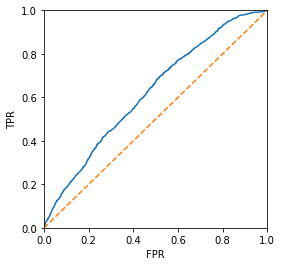

In [48]:
# False positive rate (FPR): nothing is classified as positive
# False negative rate (FNR): everything is classified as negative
print('fnr', (binary_predictions == 0)[ground_truth == 1].mean())

from sklearn import metrics 
fpr, tpr, thresholds = metrics.roc_curve(y_true=ground_truth, y_score=predictions)
metrics.roc_auc_score(y_true=ground_truth, y_score=predictions)
plt.figure(figsize=[4, 4])
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('FPR')
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], linestyle='--')

In [ ]:
train_x = train
train_y = train['IS_CRASH']
lr = LogisticRegression(class_weight={0:0.9998561817429925,1:0.0001438182570075391},penalty='none',max_iter=1000)
lr.fit(train_x, train_y)

<AxesSubplot:>

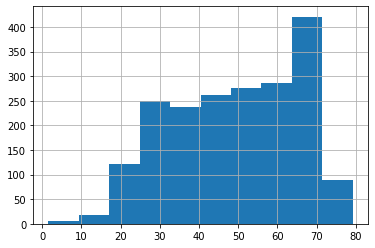

In [15]:
train.query('IS_CRASH==1').TMIN.hist()

<AxesSubplot:>

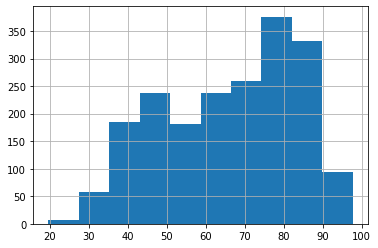

In [16]:
train.query('IS_CRASH==1').TMAX.hist()

<AxesSubplot:>

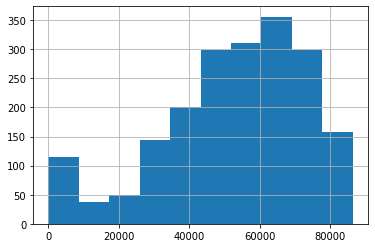

In [17]:
train.query('IS_CRASH==1').EVENT_TIME.hist()